
# Some Applications of Kalman Filter in Finance
<br />

In [1]:
!pip install empyrical

In [2]:
!pip install pykalman

In [3]:
# Import a Kalman filter and other useful libraries
from pykalman import KalmanFilter

In [4]:
import numpy as np
import pandas as pd
import cvxpy as cp
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

import empyrical as emp

In [5]:
from scipy import stats
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

import warnings
warnings.filterwarnings("ignore")

In [6]:
from scipy import poly1d
from sklearn.preprocessing import scale

# Pairs trading

In [7]:
yf.pdr_override()
# Pairwise test US top ETFs
etf_list = ['EWH', 'EWZ', 'XLF', 'QQQ', 'SPY']

In [8]:
start = "2000-08-01"
end = "2003-12-31"
prices = pdr.get_data_yahoo(etf_list, start=start, end=end)[['Adj Close']]
prices.interpolate(inplace = True, limit_direction="both")
prices = prices.iloc[1: , :]

[*********************100%%**********************]  5 of 5 completed


In [9]:
X = prices.apply(np.log).xs('Adj Close',axis=1)
T, N = X.shape
X.head()

Ticker,EWH,EWZ,QQQ,SPY,XLF
Date,,,,,
2000-08-02,1.901895,2.108073,4.303109,4.538007,2.571465
2000-08-03,1.925206,2.101473,4.345458,4.544900,2.597579
2000-08-04,1.925206,2.140438,4.341997,4.550251,2.635515
2000-08-07,1.943472,2.140438,4.365302,4.562136,2.638331
2000-08-08,1.915947,2.140438,4.385423,4.565926,2.638331


In [10]:
log_returns = prices.apply(np.log).apply(np.diff).xs('Adj Close',axis=1)
X = X[log_returns.var().sort_values().index.tolist()[-50:]]
X.head()

Ticker,SPY,XLF,EWH,EWZ,QQQ
Date,,,,,
2000-08-02,4.538007,2.571465,1.901895,2.108073,4.303109
2000-08-03,4.544900,2.597579,1.925206,2.101473,4.345458
2000-08-04,4.550251,2.635515,1.925206,2.140438,4.341997
2000-08-07,4.562136,2.638331,1.943472,2.140438,4.365302
2000-08-08,4.565926,2.638331,1.915947,2.140438,4.385423


In [11]:
X = X[["EWH", "EWZ"]]
X.head()

Ticker,EWH,EWZ
Date,,
2000-08-02,1.901895,2.108073
2000-08-03,1.925206,2.101473
2000-08-04,1.925206,2.140438
2000-08-07,1.943472,2.140438
2000-08-08,1.915947,2.140438


<Axes: xlabel='Date'>

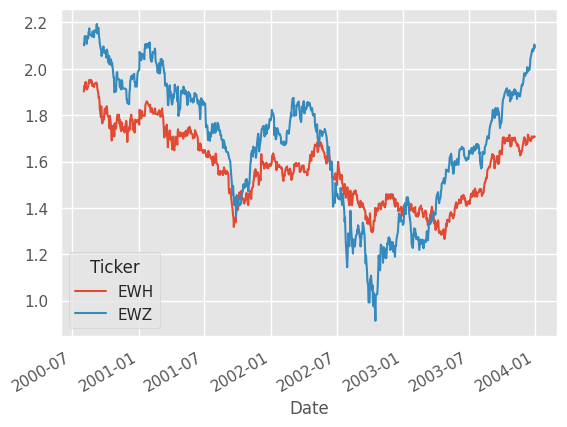

In [12]:
X.plot()


## 2. Cointegration Test

In [13]:
# Pairwise test
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue <= 0.01: #99% confidence level
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [14]:
# Identify cointegrated pairs
scores, pvalues, pairs = find_cointegrated_pairs(X)

In [15]:
pvalues

array([[1.        , 0.26536522],
       [1.        , 1.        ]])

In [16]:
pvalues_df = pd.DataFrame(pvalues, columns = X.columns, index = X.columns)
pvalues_df

Ticker,EWH,EWZ
Ticker,,
EWH,1.0,0.265365
EWZ,1.0,1.000000


In [17]:
# Focus on one pair for this project
pairs = [['EWH','EWZ']]

In [18]:
def visualize_diff(pair):
    diff = X[pair[0]]-X[pair[1]]
    plt.figure(figsize = (10,5))
    plt.axhline(diff.mean(), color='red', linestyle='--') # Add the mean, color='r', linestyle=':')
    plt.title(f"{pair[0]}-{pair[1]}")
    plt.plot(diff)

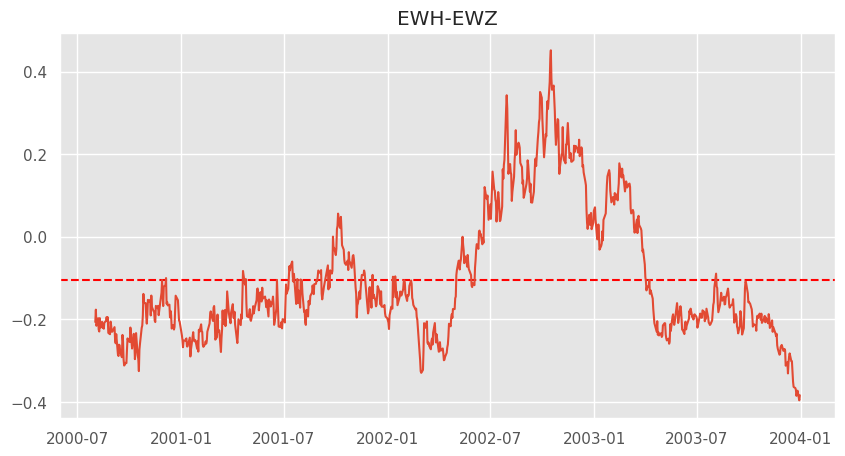

In [19]:
for pair in pairs:
    visualize_diff(pair)

## 3. Trading Strategy Design

### Static vs Time-varying Parameters

Static Least Squares

In [20]:
# Fit static least squares using training set
def static_ls(pair, X):
    S1 = X[pair[0]]
    S2 = X[pair[1]]
    S2 = sm.add_constant(S2)
    results = sm.OLS(S1, S2).fit()
    S2 = X[pair[1]]
    mu = results.params['const']
    gamma = results.params[pair[1]]
    return mu, gamma

Rolling Least Squares

In [21]:
def rolling_ls(pair, X, lb):
    S1 = X[pair[0]]
    S2 = X[pair[1]]
    S2 = sm.add_constant(S2)
    mod = RollingOLS(S1, S2, window = lb, expanding = True, min_nobs = 5)
    rolling_params = mod.fit(params_only=True)
    params = rolling_params.params.copy()
    params = params.rename(columns={"const": "mu", pair[1]: "gamma"})
    params = params.fillna(method = 'bfill')
    return params.mu.to_numpy(), params.gamma.to_numpy()

Kalman Filter

In [22]:
def kalman_filter(pair, X):
    A = np.eye(2)
    C = sm.add_constant(X[pair[1]].values, prepend=True)[:, np.newaxis]
    # Kalman filter model
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                  initial_state_mean=[0, 0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=C,
                  observation_covariance=0.01,
                  transition_covariance=0.00001 * np.eye(2))
    state_means, state_covs = kf.filter(X[pair[0]].values)
    mu = state_means[:, 0]
    gamma = state_means[:, 1]
    return mu, gamma


### Optimal Threshold Estimation

Parametric Approach (Gaussian)

In [23]:
# Helper function for calculating z-score of price
def zscore(series):
    z = (series - series.mean()) / np.std(series)
    return z, series.mean(), np.std(series)

# Calculate optimal threshold with Parametric method
def param_thres(spread):
    x = np.arange(0,4,0.01)
    y_empirical = stats.norm.cdf(x, loc = zscore(spread)[1], scale = zscore(spread)[2])
    profit = x*(1-y_empirical)
    thres = x[np.argmax(profit)]
    return thres

Non-parametric Approach

In [24]:
def non_param_thres(spread, estimation, trades, J = 50):
    key = 'zscore_' + estimation
    D = np.zeros((J-1, J))
    for i in range(J-1):
        for j in range(J):
            if j == i:
                D[i][j] = 1
            elif j == i+1:
                D[i][j] = -1
    zscore = trades[key].fillna(0).to_numpy()
    s = np.linspace(min(zscore), max(zscore), J)
    f_bar = [trades[trades[key] >= si][key].count() for si in s]
    f_star = np.linalg.inv(np.eye(J)+0.3*D.T@D)@f_bar
    profit = s * f_star
    thres = s[np.argmax(profit)]
    return thres

### Implement Pairs Trading Strategy

Generate Trading Signals

In [25]:
def trading_signal(trades, estimation, thres):
    T = len(trades.index)
    signal = np.zeros(T)
    key = 'zscore_' + estimation
    # Initial position
    if trades.iloc[0][key] >= -thres:
        signal[0] = -1
    elif trades.iloc[0][key] <= thres:
        signal[0] = 1
    # Trading strategy
    for j in range(1,T):
        prev = trades.iloc[j-1]
        row = trades.iloc[j]
        if signal[j-1] == 0:
            if row[key] <= thres:
                signal[j] = 1
            elif row[key] >= -thres:
                signal[j] = -1
            else:
                signal[j] = 0
        elif signal[j-1] == 1:
            if row[key] >= 0:
                signal[j] = 0
            else:
                signal[j] = signal[j-1]
        else:
            if row[key] <= 0:
                signal[j] = 0
            else:
                signal[j] = signal[j-1]
    trades['signal_'+estimation] = signal
    return trades

In [26]:
def pairs_trade (pair, train_pct = 0.5, param = True):
    # Separate dataset into training and testing
    T_train = int(T * train_pct)
    T_test = T - T_train
    X_test = X[T_test:]
    X_train = X[:T_train]

    coef_stat = static_ls(pair, X_train)
    coef_roll = rolling_ls(pair, X, T_train)
    coef_kf = kalman_filter(pair, X)
    coef_roll_1 = rolling_ls(pair, X, 300)
    coef_roll_2 = rolling_ls(pair, X, 400)
    coef_roll_3 = rolling_ls(pair, X, 500)
    mu_stat, gamma_stat = coef_stat[0], coef_stat[1]
    mu_roll, gamma_roll = coef_roll[0], coef_roll[1]
    mu_roll_1, gamma_roll_1 = coef_roll_1[0], coef_roll_1[1]
    mu_roll_2, gamma_roll_2 = coef_roll_2[0], coef_roll_2[1]
    mu_roll_3, gamma_roll_3 = coef_roll_3[0], coef_roll_3[1]
    mu_kf, gamma_kf = coef_kf[0], coef_kf[1]

    plt.figure(figsize=(10,3))
    plt.plot(np.ones(T)*mu_stat)
    plt.plot(mu_roll_1)
    plt.plot(mu_roll_2)
    plt.plot(mu_roll_3)
    plt.plot(mu_kf)
    plt.legend(["Static LS", f"Rolling LS (win =  300)", f"Rolling LS (win =  400)", f"Rolling LS (win =  500)", "Kalman"], fontsize = 14, loc = "upper left")
    plt.title("Estimation of $\mu$")

    plt.figure(figsize=(10,3))
    plt.plot(np.ones(T)*gamma_stat)
    plt.plot(gamma_roll_1)
    plt.plot(gamma_roll_2)
    plt.plot(gamma_roll_3)
    plt.plot(gamma_kf)
    plt.legend(["Static LS", f"Rolling LS (win =  300)", f"Rolling LS (win =  400)", f"Rolling LS (win =  500)", "Kalman"], fontsize = 14, loc = "upper left")
    plt.title("Estimation of $\gamma$")

    # Plot cointegrated series
    plt.figure(figsize=(10,5))
    plt.title(f"Static LS: {pair[0]}, {pair[1]}")
    plt.plot(X[pair[0]])
    plt.plot(mu_stat+gamma_stat*X[pair[1]])
    plt.legend(['$y_{1t}$', '$\mu + \gamma * y_{2t}$'], fontsize = 14)

    plt.figure(figsize=(10,5))
    plt.title(f"Rolling LS: {pair[0]}, {pair[1]}")
    plt.plot(X[pair[0]])
    plt.plot(mu_roll+gamma_roll*X[pair[1]])
    plt.legend(['$y_{1t}$', '$\mu_t + \gamma_t * y_{2t}$'], fontsize = 14)

    # KALMAN
    plt.figure(figsize=(10,5))
    plt.title(f"Kalman: {pair[0]}, {pair[1]}")
    plt.plot(X[pair[0]])
    plt.plot(mu_kf+gamma_kf*X[pair[1]])
    plt.legend(['$y_{1t}$', '$\mu_t + \gamma_t * y_{2t}$'], fontsize = 14)


    # Normalize weights and calculate spread
    spread_stat = X[pair[0]]/(1+gamma_stat) - gamma_stat*X[pair[1]]/(1+gamma_stat) - mu_stat/(1+gamma_stat)
    trades_stat = pd.concat([zscore(spread_stat)[0], spread_stat], axis=1)
    spread_roll = X[pair[0]]/(1+gamma_roll) - gamma_roll*X[pair[1]]/(1+gamma_roll) - mu_roll/(1+gamma_roll)
    trades_roll = pd.concat([zscore(spread_roll)[0], spread_roll], axis=1)
    spread_kf = X[pair[0]]/(1+gamma_kf) - gamma_kf*X[pair[1]]/(1+gamma_kf) - mu_kf/(1+gamma_kf)
    trades_kf = pd.concat([zscore(spread_kf)[0], spread_kf], axis=1)
    trades = pd.concat([trades_stat, trades_roll, trades_kf], axis=1)
    trades.columns = ["zscore_stat", "spread_stat", "zscore_roll", "spread_roll", "zscore_kf", "spread_kf"]

    # Plot spread
    trades[['spread_stat', 'spread_roll','spread_kf']].plot(figsize = (10,5))
    plt.title(f'Spread: {pair[0]},{pair[1]}')
    plt.legend(['Static LS', 'Rolling LS', 'Kalman'], fontsize = 14)

    # Calculate optimal threshold
    if param: # Parametric method
        thres = [0.75, 0.75, 0.75]
    else: # Non-parametric method
        thres = []
        thres.append(non_param_thres(spread_stat[:T_train], "stat", trades[:T_train]))
        thres.append(non_param_thres(spread_roll[:T_train], "roll", trades[:T_train]))
        thres.append(non_param_thres(spread_roll[:T_train], "kf", trades[:T_train]))

    for i, est in enumerate(['stat', 'roll', 'kf']):
        # Implement trading strategy
        trading_signal(trades, est, thres[i])
        # Plot trading signals
        plt.figure(figsize = (10,5))
        plt.title(f'Trading Signals ({est}): {pair[0]},{pair[1]}')
        plt.plot(trades['zscore_'+est], c='k')
        plt.plot(trades['signal_'+est], c='r',lw=0.5)
        plt.axhline(-thres[i], ls=':', c='gray')
        plt.axhline(0, ls='-', c='gray')
        plt.axhline(thres[i], ls=':', c='gray')

    # Compute and Plot returns
    spread_stat_returns = spread_stat.diff()
    returns_stat = spread_stat_returns * trades['signal_stat'].shift().fillna(0)
    trades['returns_stat'] = (1 + returns_stat.cumsum()).fillna(1)
    trades['drawdown_stat'] = trades['returns_stat'] - trades['returns_stat'].cummax()
    spread_roll_returns = spread_roll.diff()
    returns_roll = spread_roll_returns * trades['signal_roll'].shift().fillna(0)
    trades['returns_roll'] = (1 + returns_roll.cumsum()).fillna(1)
    trades['drawdown_roll'] = trades['returns_roll'] - trades['returns_roll'].cummax()
    spread_kf_returns = spread_kf.diff()
    returns_kf = spread_kf_returns * trades['signal_kf'].shift().fillna(0)
    trades['returns_kf'] = (1 + returns_kf.cumsum()).fillna(1)
    trades['drawdown_kf'] = trades['returns_kf'] - trades['returns_kf'].cummax()
    trades[['returns_stat', 'returns_roll','returns_kf']].plot(figsize=(10,5))
    plt.title(f'Cumulative Returns: {pair[0]},{pair[1]}')
    plt.axvline(trades.index[T_train], color='gray')
    plt.legend(['Static LS', 'Rolling LS', 'Kalman'], fontsize = 14)
    trades[['drawdown_stat', 'drawdown_roll','drawdown_kf']].plot(figsize=(10,5))
    plt.title(f'Drawdown: {pair[0]},{pair[1]}')
    plt.axvline(trades.index[T_train], color='gray')
    plt.legend(['Static LS', 'Rolling LS', 'Kalman'], fontsize = 14)
    return trades

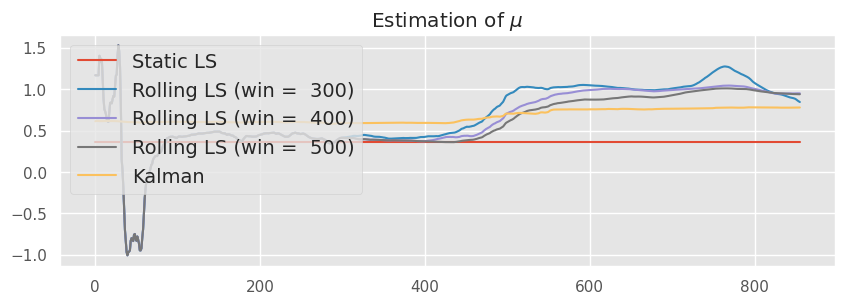

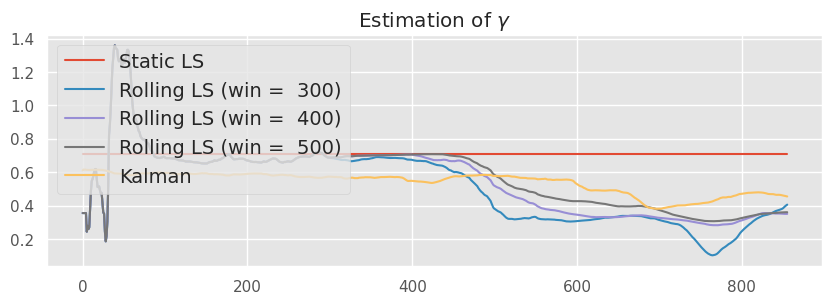

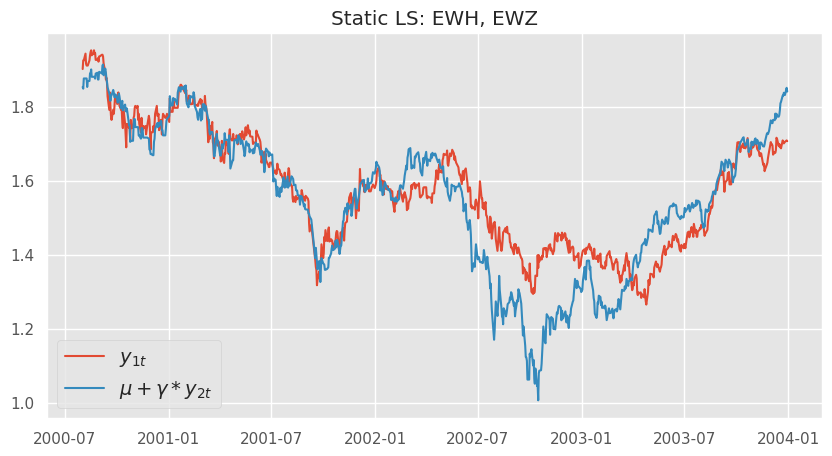

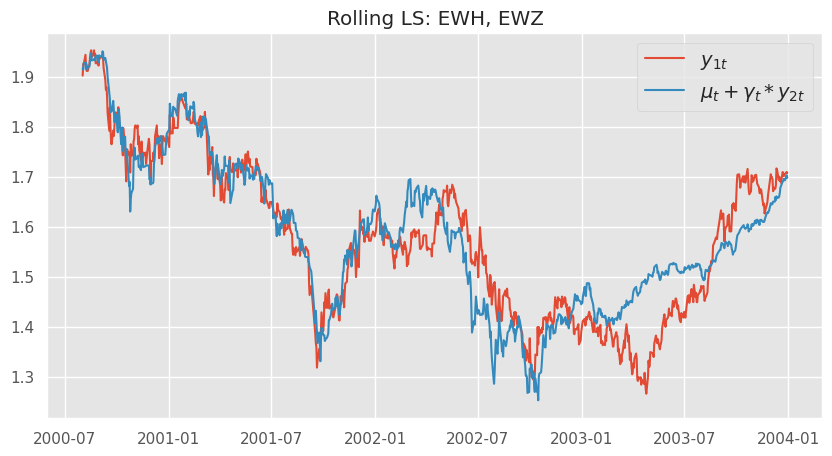

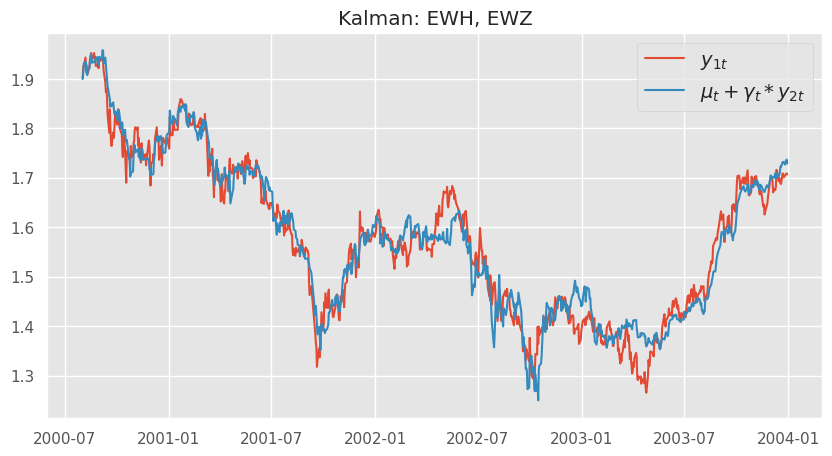

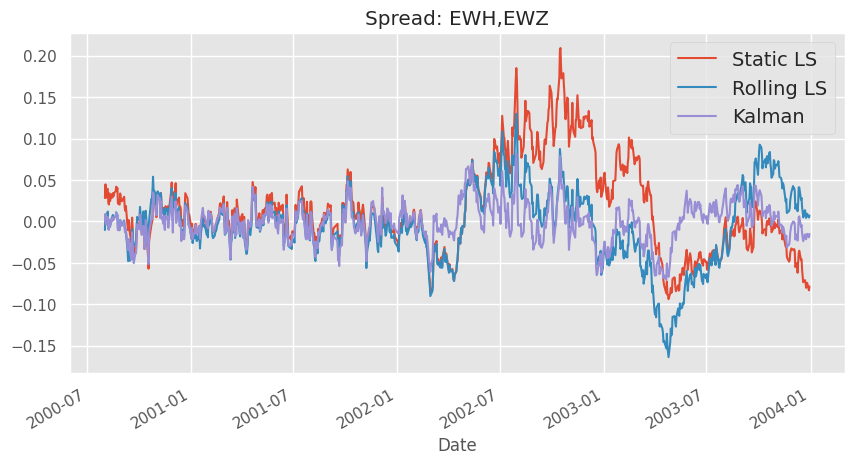

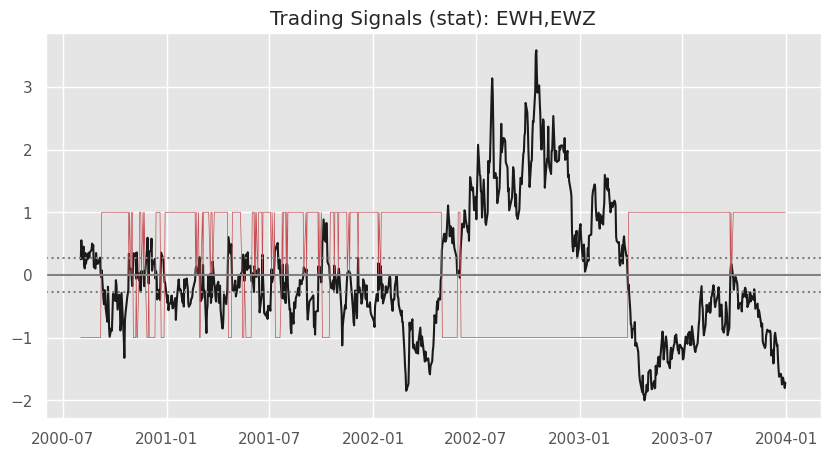

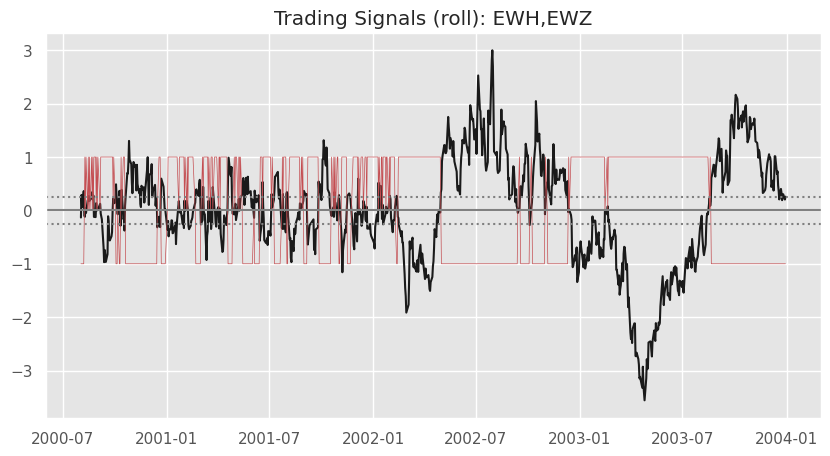

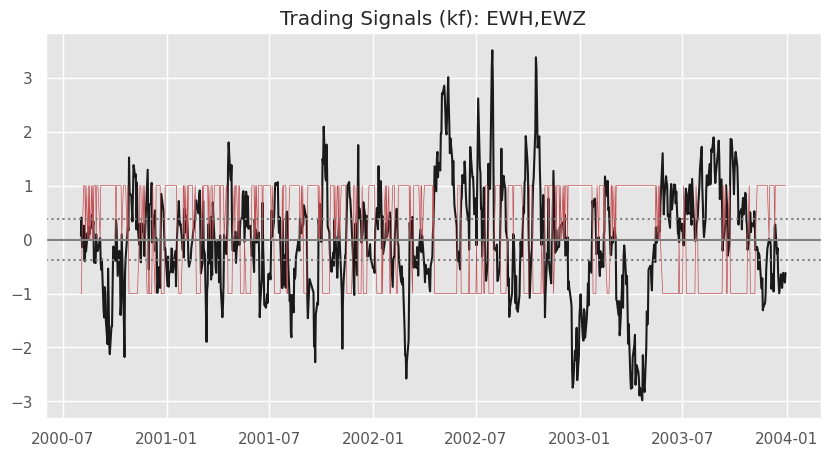

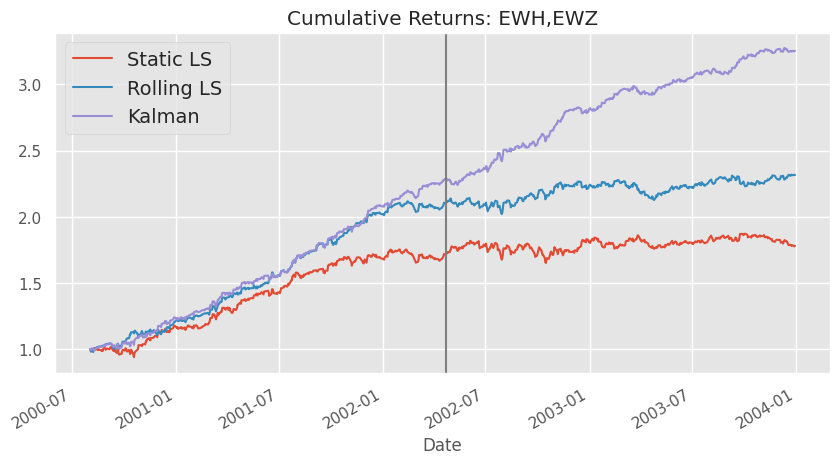

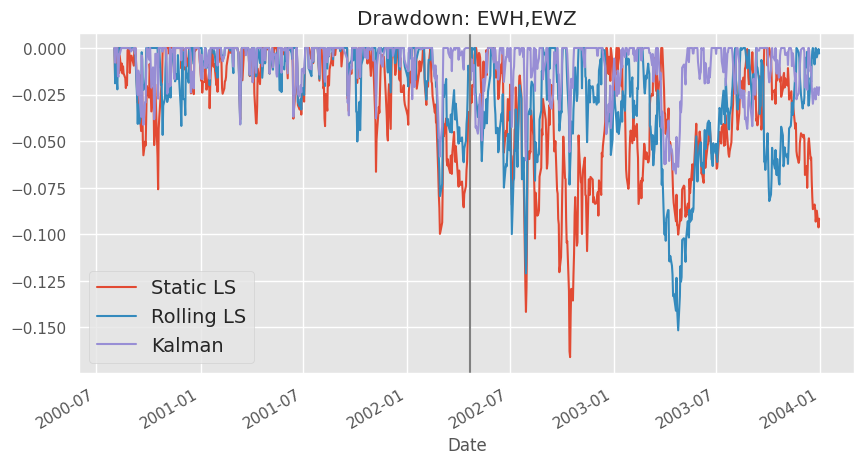

In [27]:
# Analyze pairs
for i, pair in enumerate(pairs):
   result = pairs_trade(pair, 0.5, False)
   kf_nonparam = result["returns_kf"]

# CAPM (Capital Asset Price Model)

In [28]:
stock_namelist = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'NFLX', 'NVDA', 'TSLA']
Prices = pdr.get_data_yahoo(stock_namelist, start='2012-01-01', end='2015-01-01')['Adj Close']
# Y = Prices.apply(np.log).apply(np.diff)
# Y.index = Prices.index[1:]
Y = Prices

factor = pdr.get_data_yahoo('^GSPC',  start='2012-01-01', end='2015-01-01')[['Adj Close']]
# x = factor.apply(np.log).apply(np.diff)['Adj Close']
# x.index = factor.index[1:]
# x = np.squeeze(x,axis = 1)
x = factor['Adj Close']


[*********************100%%**********************]  7 of 7 completed
[*********************100%%**********************]  1 of 1 completed


In [29]:
Y.head()

Ticker,AAPL,AMZN,GOOGL,MSFT,NFLX,NVDA,TSLA
Date,,,,,,,
2012-01-03,12.433825,8.9515,16.651901,21.238756,10.320000,3.219731,1.872000
2012-01-04,12.500645,8.8755,16.723724,21.738581,11.492857,3.256423,1.847333
2012-01-05,12.639426,8.8805,16.491741,21.960730,11.328571,3.373379,1.808000
2012-01-06,12.771557,9.1305,16.266768,22.301878,12.327143,3.334394,1.794000
2012-01-09,12.751302,8.9280,15.577077,22.008331,14.025714,3.334394,1.816667


In [30]:
stock_name = 'AAPL'
y = Y[stock_name]

In [31]:
(T, N) = Y.shape
print("T is:", T)

T is: 754


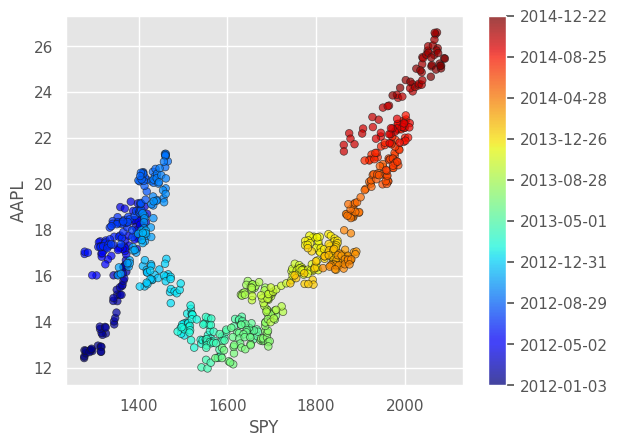

In [32]:
# Plot data and use colormap to indicate the date each point corresponds to
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, T)
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(cb.ax.get_yticks().tolist()))
cb.ax.set_yticklabels([str(p.date()) for p in x[::T//9].index])
plt.xlabel('SPY')
plt.ylabel(stock_name);

In [33]:
# Fit static least squares using training set
def static_ls(x, y):
    x = sm.add_constant(x)
    results = sm.OLS(y, x).fit()
    # alpha = results.params['const']
    # beta = results.params[pair[1]]
    return results.params

In [34]:
params = static_ls(x, Y)
Gamma = np.zeros( (2,N) )
for i in range(N):
  Gamma[0,i] = params[i]['const']
  Gamma[1,i] = params[i]['Adj Close']

print(Gamma)

[[ 5.45598078e+00 -2.34746451e+00 -1.32448740e+01 -9.23722969e+00
  -9.66702000e+01 -4.12325408e-01 -3.00202412e+01]
 [ 7.29461122e-03  1.00090691e-02  2.14667517e-02  2.31773178e-02
   7.96530324e-02  2.43462539e-03  2.30061060e-02]]


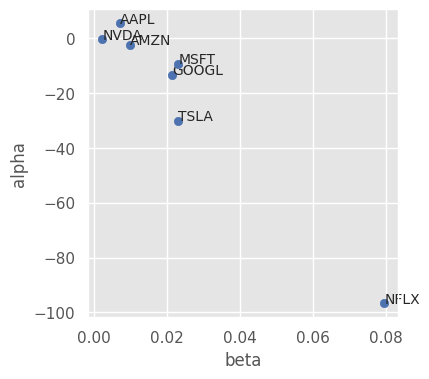

In [35]:
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot()

for i in range(N):
    ax.scatter( Gamma[1,i], Gamma[0,i],color='b')
    ax.text( Gamma[1,i], Gamma[0,i], '%s' % ( stock_namelist[i]), size=10, zorder=1)


ax.set_xlabel('beta')
ax.set_ylabel('alpha')
plt.show()

In [36]:
def rolling_ls(x, y, lb):

    x = sm.add_constant(x)
    mod = RollingOLS(y, x, window = lb)
    rolling_params = mod.fit(params_only=True)
    params = rolling_params.params.copy()
    params = params.fillna(method = 'bfill')
    return params

In [37]:
params = static_ls(x, y)
alpha_stat_LS = params['const']
beta_stat_LS = params['Adj Close']

In [38]:
window = 60
params = rolling_ls(x, y, window)
alpha_rolling_LS = params['const']
beta_rolling_LS = params['Adj Close']

Text(0.5, 1.0, 'Rolling LS')

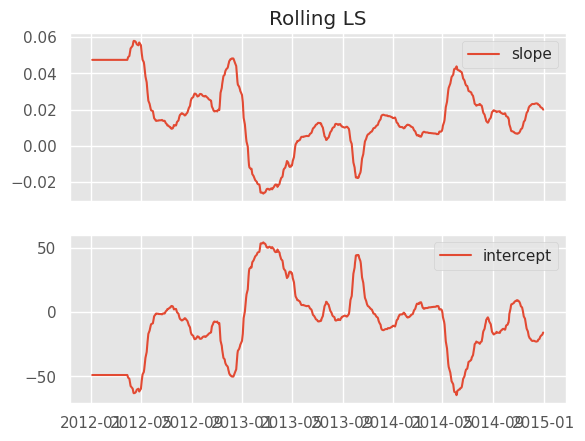

In [39]:
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x.index, beta_rolling_LS , label='slope')
axarr[0].legend()
axarr[1].plot(x.index, alpha_rolling_LS, label='intercept')
axarr[1].legend()
axarr[0].set_title("Rolling LS")

In [40]:
trans_cov =  0.00001*np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[x], [np.ones(T)]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=0.01,
                  transition_covariance=trans_cov)



In [41]:
# Use the observations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(y.values)
alpha_Kf = state_means[:,1]
beta_Kf = state_means[:,0]

Text(0.5, 1.0, 'Kalman')

<Figure size 800x300 with 0 Axes>

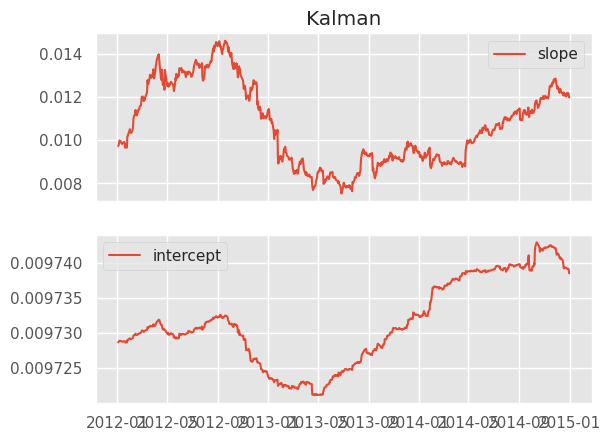

In [42]:
fig = plt.figure(figsize = (8,3))
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x.index, beta_Kf, label='slope')
axarr[0].legend()
axarr[1].plot(x.index, alpha_Kf, label='intercept')
axarr[1].legend()
axarr[0].set_title("Kalman")

Text(0.5, 1.0, 'Estimation of the intercept')

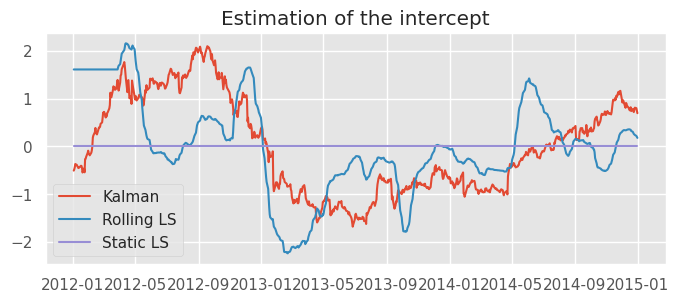

In [43]:
fig = plt.figure(figsize = (8,3))
ax = fig.add_subplot()
ax.plot(x.index, scale( beta_Kf), label='Kalman')
ax.plot(x.index, scale(beta_rolling_LS), label='Rolling LS')
ax.plot(x.index, np.repeat(beta_stat_LS,T), label='Static LS')
ax.legend()
plt.title('Estimation of the intercept')

Text(0.5, 1.0, 'Estimation of the slope')

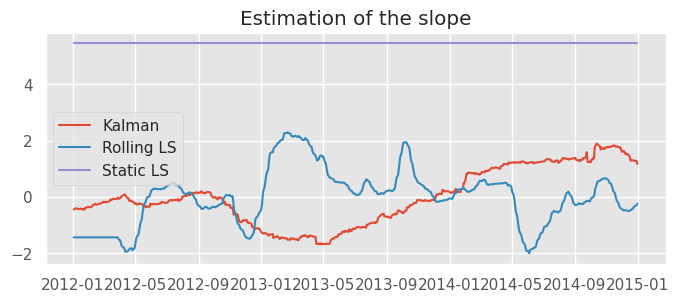

In [44]:
fig = plt.figure(figsize = (8,3))
ax = fig.add_subplot()
ax.plot(x.index, scale(alpha_Kf), label='Kalman')
ax.plot(x.index, scale(alpha_rolling_LS), label='Rolling LS')
ax.plot(x.index, np.repeat(alpha_stat_LS,T), label='Static LS')
ax.legend()
plt.title('Estimation of the slope')

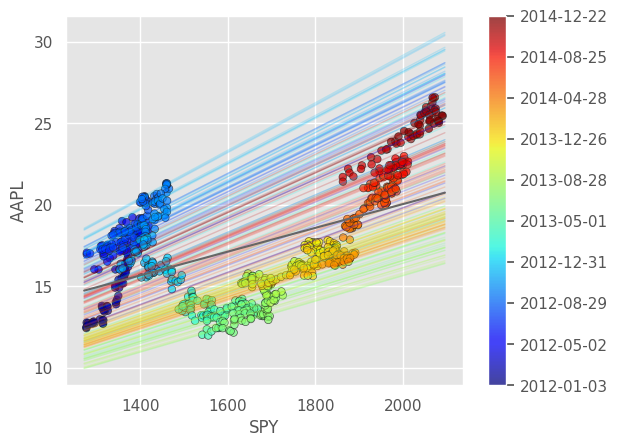

In [45]:
# Plot data points using colormap
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(cb.ax.get_yticks().tolist()))
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])

# Plot every fifth line
step = 5
xi = np.linspace(x.min()-5, x.max()+5, 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

# Plot the OLS regression line
xi = np.linspace(x.min()-5, x.max()+5, 2)
plt.plot(xi, poly1d(np.polyfit(x, y, 1))(xi), '0.4')



# Label axes
plt.xlabel('SPY')
plt.ylabel('AAPL');

Text(0.5, 1.0, '$\\alpha$ + $\\beta$ * market')

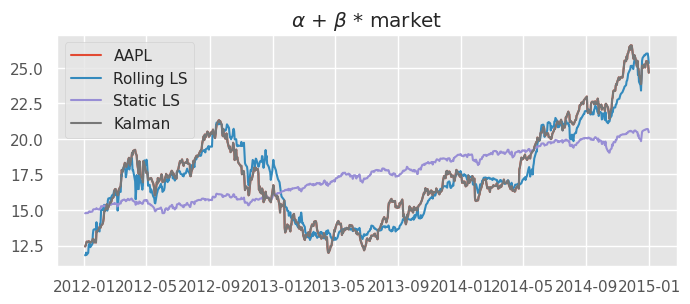

In [46]:
fig = plt.figure(figsize = (8,3))
ax = fig.add_subplot()
ax.plot(y, label = 'AAPL')
ax.plot(alpha_rolling_LS + beta_rolling_LS*x, label = 'Rolling LS')
ax.plot(alpha_stat_LS + beta_stat_LS*x, label = 'Static LS')
ax.plot(alpha_Kf + beta_Kf*x, label = 'Kalman')
plt.legend()
plt.title("$\\alpha$ + $\\beta$ * market")